In [1]:
# Load and preprocess the dataset.
# Note that this cell might take a couple of minutes to execute. Every image from the dataset is stored
# as a separate file, so loading them is slow.

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from types import NoneType

letters_in_BG_alphabet = 30

def move_class_numbers_down(num):
    """Move class numbers down accordingly because the Bulgarian alphabet has 3 fewer letters than the Russian."""
    if num >= 31:
        return num - 3
    elif num >= 29:
        return num -2
    elif num >= 7:
        return num - 1
    else:
        return num

def read_bg_letters(filepath):
    """Extract the Bulgarian letters from the dataset and return it as pandas dataframe."""
    df = pd.read_csv(filepath)
    df = df[['filename', 'Russian']]
    df['Russian'] = df['Russian'].astype(int)
    # Take only the Bulgarian letters. Resulting data frame contains only Bulgarian letters.
    df = df[
        (df['Russian'] != -1) &
        (df['Russian'] != 6) &
        (df['Russian'] != 28) &
        (df['Russian'] != 30)]
    # Move class numbers "down" because we excluded three letters.
    df['Russian'] = df['Russian'].apply(move_class_numbers_down)
    return df

def to_nparrays(df):
    # Read images.
    df['filename'] = df['filename'].apply(lambda fn: cv2.imread('../datasets/cmnist/all-binary/' + fn, cv2.IMREAD_GRAYSCALE))
    # There are some images that 'cv2' cannot read. Exclude them.
    # They all have Cyrillic letters in the filename and maybe that's the reason.
    df = df[df['filename'].apply(type) != NoneType]
    
    xs = df['filename'].values.tolist()
    xs = np.array(xs) / 255.0
    ys = tf.keras.utils.to_categorical(np.array(df['Russian']), letters_in_BG_alphabet)
    return xs, ys

train_df = read_bg_letters('../datasets/cmnist/train.csv')
test_df = read_bg_letters('../datasets/cmnist/test.csv')

x_train, y_train = to_nparrays(train_df)
x_test, y_test = to_nparrays(test_df)

img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

print("Total examples:", x_train.shape[0] + x_test.shape[0])
print("Training examples:", x_train.shape[0])
print("Testing examples:", x_test.shape[0])
print("Image rows:", img_rows)
print("Image cols:", img_cols)

Total examples: 77443
Training examples: 68798
Testing examples: 8645
Image rows: 28
Image cols: 28


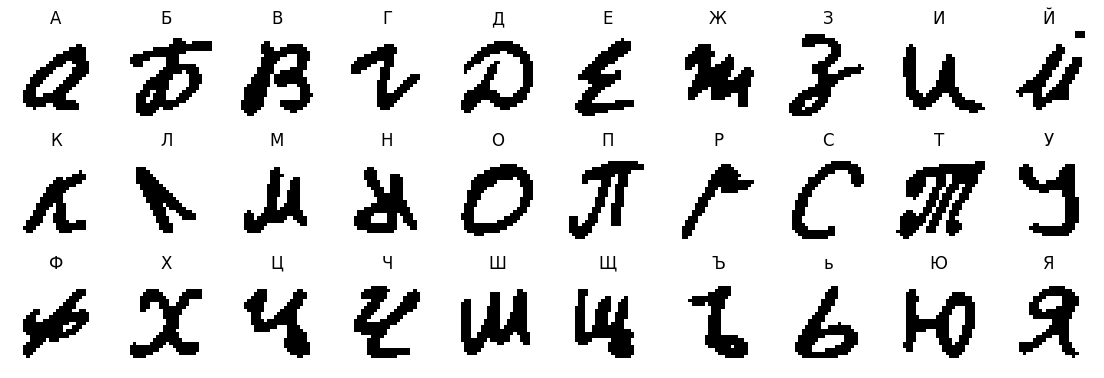

In [9]:
# Show some examples.
import matplotlib.pyplot as plt

def a_to_ia(xs, ys):
    """Returns a list of images of Bulgarian letters 'А' to 'Я'."""
    images = list()
    for i in range(0, 30):
        index = np.where(ys == i)[0][0]
        images.append(xs[index])
    return images

def show_images(images):
    images = list(map(lambda img: (img * 255.0).astype(np.uint8), images))
    letters = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О',
               'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'ь', 'Ю', 'Я']
    
    plt.figure(figsize=(14, 4.5))
    for i in range(0, 30):
        plt.subplot(3, 10, i + 1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.title(letters[i])
    
show_images(a_to_ia(x_train, np.argmax(y_train, axis=-1)))
# Note: The images from the dataset are black letter on white background. So the images below should also be displayed in this way.
# If you are using PyCharm IDE and the images below are shown in a different way, it might be because you are using dark theme.
# Try using light theme to view them as the originals.

In [4]:
# Create model.
from tensorflow.keras import layers

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(img_rows, img_cols, 1)),
        layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(letters_in_BG_alphabet, activation='softmax')
    ]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,702 (1.64 MB)

 Trainable params: 428,702 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Compile, train and save.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 256
epochs = 20
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.save("../models/bg-model.keras")

Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 36s 125ms/step - accuracy: 0.4485 - loss: 1.9501 - val_accuracy: 0.9152 - val_loss: 0.2986
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 31s 114ms/step - accuracy: 0.8593 - loss: 0.4716 - val_accuracy: 0.9454 - val_loss: 0.1854
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 120ms/step - accuracy: 0.9003 - loss: 0.3272 - val_accuracy: 0.9559 - val_loss: 0.1405
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.9206 - loss: 0.2587 - val_accuracy: 0.9618 - val_loss: 0.1257
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 120ms/step - accuracy: 0.9340 - loss: 0.2170 - val_accuracy: 0.9655 - val_loss: 0.1118
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 120ms/step - accuracy: 0.9435 - loss: 0.1803 - val_accuracy: 0.9681 - val_loss: 0.1021
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.9486 - loss: 0.1643 - val_accuracy: 0.9673 - val_loss: 0.1023
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.9529 - loss: 0

In [6]:
# Run final evaluation on test and train datasets.
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

Train accuracy: 0.9963662028312683
Test accuracy: 0.9746674299240112
Train loss: 0.010653904639184475
Test loss: 0.09296204894781113


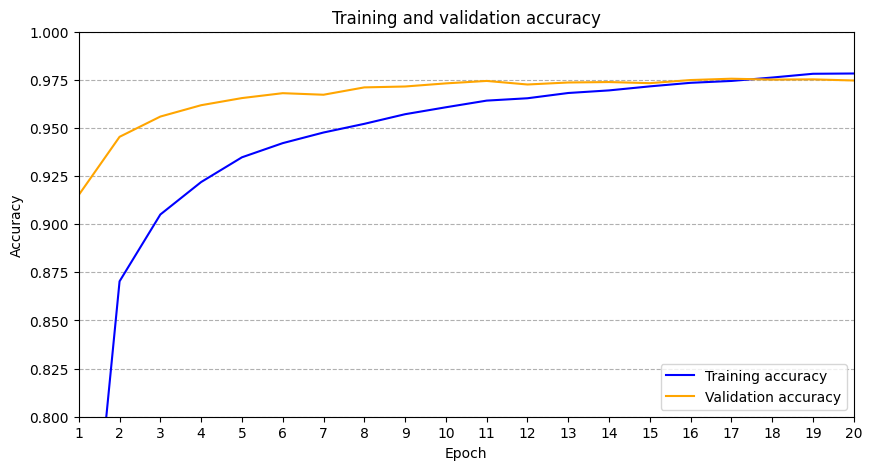

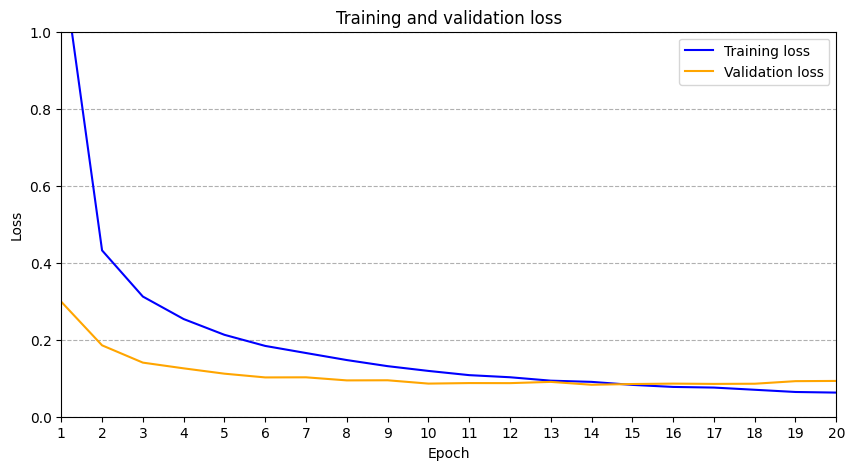

In [8]:
# Show training progress.

print('Train accuracy:', train_score[1])
print('Test accuracy:', test_score[1])
print('Train loss:', train_score[0])
print('Test loss:', test_score[0])

# Make accuracy plot.
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10, 5))
plt.gca().set_ylim([0.8, 1.0])
plt.gca().set_xlim([epochs_range[0], epochs_range[-1]])
plt.xticks(epochs_range)
plt.grid(visible=True, axis='y', linestyle='--')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs_range, history.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], color='orange', label='Validation accuracy')
plt.legend(loc='lower right')
plt.show()

# Make loss plot.
plt.figure(figsize=(10, 5))
plt.gca().set_ylim([0.0, 1])
plt.gca().set_xlim([epochs_range[0], epochs_range[-1]])
plt.xticks(epochs_range)
plt.grid(visible=True, axis='y', linestyle='--')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs_range, history.history['loss'], color='blue', label='Training loss')
plt.plot(epochs_range, history.history['val_loss'], color='orange', label='Validation loss')
plt.legend(loc='upper right')
plt.show()